In [1]:
# Import libraries
import glob
import pydicom
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import Slider
import time
import os
import re
import ipywidgets as ipyw
from scipy import ndimage
from PIL import Image, ImageOps
from zipfile import ZipFile
#import ipyvolume as ipv
import itertools
from scipy.ndimage import zoom
import SimpleITK as sitk
import scipy.ndimage
from scipy.ndimage import rotate
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#from plotly.tools import FigureFactory as FF
#from plotly.graph_objs import *
#init_notebook_mode(connected=True) 
import pandas as pd
from IPython.display import Image 
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

# Kaplan-Meier curve
from string import ascii_lowercase# Visualisation
import seaborn as sns
#sns.set(style='dark', context='talk')# Kaplan-Meier curve
from lifelines import KaplanMeierFitter 
from sksurv.nonparametric import kaplan_meier_estimator

import missingno
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter, WeibullAFTFitter , LogNormalAFTFitter, LogLogisticAFTFitter , PiecewiseExponentialRegressionFitter
from lifelines.utils import k_fold_cross_validation
from IPython.display import HTML

from radiomics import featureextractor 
import nrrd
import traceback
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py

In [2]:
class showPETCT3D:
    """ 
    Modified from ImageSlice3D to show both PET and CT in same volume
    
    """
    
    def __init__(self, volumeCT, volumePET, figsize=(100,100), cmapCT='gray', cmapPET="hot"):
        self.volumeCT  = volumeCT
        self.volumePET = volumePET
        self.figsize   = figsize
        self.cmapCT    = cmapCT
        self.cmapPET   = cmapPET
        self.vCT = [np.min(volumeCT), np.max(volumeCT)]
        self.vPET = [np.min(volumePET), np.max(volumePET)]
        # Call to select slice plane
        ipyw.interact(self.views)
    
    def views(self):
        self.volCT1 = np.transpose(self.volumeCT, [1,2,0])
        self.volCT2 = np.rot90(np.transpose(self.volumeCT, [2,0,1]), 3) #rotate 270 degrees
        self.volCT3 = np.transpose(self.volumeCT, [0,1,2])
        self.volPET1 = np.transpose(self.volumePET, [1,2,0])
        self.volPET2 = np.rot90(np.transpose(self.volumePET, [2,0,1]), 3) #rotate 270 degrees
        self.volPET3 = np.transpose(self.volumePET, [0,1,2])
        maxZ1 = self.volCT1.shape[2] - 1
        maxZ2 = self.volCT2.shape[2] - 1
        maxZ3 = self.volCT3.shape[2] - 1
        
        ipyw.interact(self.plot_slice, 
            z1=ipyw.IntSlider(min=0, max=maxZ1, step=1, continuous_update=False, 
            description='Axial:'), 
            z2=ipyw.IntSlider(min=0, max=maxZ2, step=1, continuous_update=False, 
            description='Coronal:'),
            z3=ipyw.IntSlider(min=0, max=maxZ3, step=1, continuous_update=False, 
            description='Sagittal:'))
    def plot_slice(self, z1, z2, z3):
        # Plot slice for the given plane and slice
        f,ax = plt.subplots(1,3, figsize=self.figsize)
        #print(self.figsize)
        #self.fig = plt.figure(figsize=self.figsize)
        #f(figsize = self.figsize)
        ax[0].imshow(self.volCT1[:,:,z1], cmap=plt.get_cmap(self.cmapCT), 
            vmin=self.vCT[0], vmax=self.vCT[1])
        ax[1].imshow(np.flip(self.volCT2[:,:,z2],1), cmap=plt.get_cmap(self.cmapCT), 
            vmin=self.vCT[0], vmax=self.vCT[1])
        ax[2].imshow(self.volCT3[:,:,z3], cmap=plt.get_cmap(self.cmapCT), 
            vmin=self.vCT[0], vmax=self.vCT[1])
        
        ax[0].imshow(self.volPET1[:,:,z1], cmap=plt.get_cmap(self.cmapPET), 
            vmin=self.vPET[0], vmax=self.vPET[1], alpha=0.5)
        ax[1].imshow(np.flip(self.volPET2[:,:,z2],1), cmap=plt.get_cmap(self.cmapPET), 
            vmin=self.vPET[0], vmax=self.vPET[1], alpha=0.5)
        ax[2].imshow(self.volPET3[:,:,z3], cmap=plt.get_cmap(self.cmapPET), 
            vmin=self.vPET[0], vmax=self.vPET[1], alpha=0.5)
        
        ax[0].axvline(x=z3,color='red',linewidth=5.0)
        ax[0].axhline(y=z2,color='green',linewidth=5.0)
        
        ax[1].axhline(y=z1,color='blue',linewidth=5.0)
        ax[1].axvline(x=z3,color='red',linewidth=5.0)
        
        ax[2].axhline(y=z1,color='blue',linewidth=5.0)
        ax[2].axvline(x=z2,color='green',linewidth=5.0)
        plt.show()

In [3]:
def sort_by_instance_number(image_file_list):
    data = []
    for row in image_file_list:        
        f=pydicom.dcmread(row)
        data.append({'f':row,'n':f.InstanceNumber})
    data=sorted(data,key=lambda x: x['n'])
    return [x['f'] for x in data]

def imread(fpath):
    if isinstance(fpath,list):
        image_file_list = fpath
        image_file_list = sort_by_instance_number(image_file_list)
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(image_file_list)
    elif fpath.endswith('.list'):
        with open(fpath,'r') as f:
            dicom_names = [x for x in f.read().split('\n') if len(x) > 0]
        if not os.path.exists(dicom_names[0]):
            image_file_list = [os.path.join(os.path.dirname(fpath),x) for x in dicom_names]
            image_file_list = sort_by_instance_number(image_file_list)
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(image_file_list)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()    
    return arr,spacing,origin,direction

In [4]:
def compute_suv(image_file_list):
    
    estimated = False

    raw,spacing,origin,direction = imread(image_file_list)
    
    f=pydicom.dcmread(image_file_list[0])
    
    try:
        weight_grams = float(f.PatientWeight)*1000
    except:
        traceback.print_exc()
        weight_grams = 75000
        estimated = True
        
    try:
        # Get Scan time
        scantime = datetime.datetime.strptime(f.AcquisitionTime,'%H%M%S')
        # Start Time for the Radiopharmaceutical Injection
        injection_time = datetime.datetime.strptime(f.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime,'%H%M%S.%f')
        # Half Life for Radionuclide # seconds
        half_life = float(f.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife) 
        # Total dose injected for Radionuclide
        injected_dose = float(f.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)

        # Calculate decay
        decay = np.exp(-np.log(2)*((scantime-injection_time).seconds)/half_life);
        # Calculate the dose decayed during procedure
        injected_dose_decay = injected_dose*decay; # in Bq        
    except:
        traceback.print_exc()
        decay = np.exp(-np.log(2)*(1.75*3600)/6588); # 90 min waiting time, 15 min preparation
        injected_dose_decay = 420000000 * decay; # 420 MBq
        estimated = True
    
    # Calculate SUV # g/ml
    suv = raw*weight_grams/injected_dose_decay
    
    return suv, estimated, raw,spacing,origin,direction

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [6]:
def resize_volume(img, new_shape):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = new_shape[-1]
    desired_width = new_shape[0]
    desired_height = new_shape[1]
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [7]:
def convert_to_hu(dicom_file):
    bias = dicom_file.RescaleIntercept
    slope = dicom_file.RescaleSlope
    pixel_values = dicom_file.pixel_array
    new_pixel_values = (pixel_values * slope) + bias
    return new_pixel_values

In [8]:
def map_ax(vol_arr,axx):
    map_xy = np.ndarray.max(vol_arr, axx)
    return map_xy

In [9]:
def norm(arr):
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))*2**8

In [10]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [11]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [12]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

In [13]:
def blur(a):
    kernel = np.array([1.0,1.5,1.0]) # Here you would insert your actual kernel of any size
    a = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 0, a)
    a = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 1, a)
    return a

In [14]:
def get8n(x, y, shape):
    out = []
    maxx = shape[0]-1
    maxy = shape[1]-1
    
    #top left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #top center
    outx = x
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #top right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #left
    outx = min(max(x-1,0),maxx)
    outy = y
    out.append((outx,outy))
    
    #right
    outx = min(max(x+1,0),maxx)
    outy = y
    out.append((outx,outy))
    
    #bottom left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    #bottom center
    outx = x
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    #bottom right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    return out

def region_growing(img, seed):
    seed_points = []
    outimg = np.zeros_like(img)
    seed_points.append((seed[0], seed[1]))
    processed = []
    while(len(seed_points) > 0):
        pix = seed_points[0]
        outimg[pix[0], pix[1]] = 255
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] != 0:
                outimg[coord[0], coord[1]] = 255
                if not coord in processed:
                    seed_points.append(coord)
                processed.append(coord)
        seed_points.pop(0)
        #cv2.imshow("progress",outimg)
        #cv2.waitKey(1)
    return outimg

Features Exploration

In [15]:
def getSec(s):
    b =int(s[0:2]) *3600 + int(s[2:4])*60 + int(s[4:6])
    return b

In [16]:
special_list_id = ["LC00028","LC00308","LC01073","LC01473","LC01475","LC01492","LC01521","LC01523","LC01551","LC01860","LC01888","LC01993","LC01996","LC02157","LC02393","LC02473","LC02476","LC02504","LC02516","LC02677","LC02762","LC03036","LC03100","LC03266","LC03990","LC04040","LC04246","LC04366","LC04452","LC04859","LC05911","LC05936","LC06028","LC06038","LC06187","LC06196","LC06292","LC06298","LC06317","LC06321","LC06338","LC06342","LC06606","LC07317","LC08794","LC09649","LC09755","LC09823","LC09827","LC09834","LC09837","LC09858","LC09884","LC09893","LC09917","LC09934","LC09938","LC09941","LC09943","LC09963","LC09976","LC10032","LC10037","LC10039","LC10054","LC10087","LC21394","LC22147","LC23886"]
special_list_id2= ["LC01973","LC02421","LC02696","LC02994","LC03409","LC04053","LC05150","LC05269","LC05531","LC06286","LC06314","LC06943","LC07529","LC08414","LC09826","LC09828","LC09950"]


LC00028


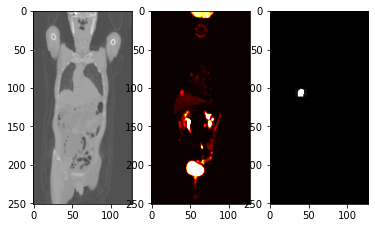

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0801098



LC00308


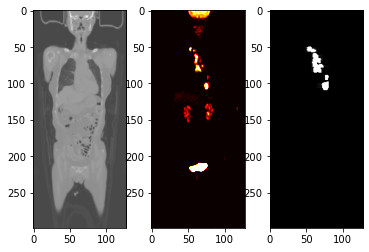

LC01073


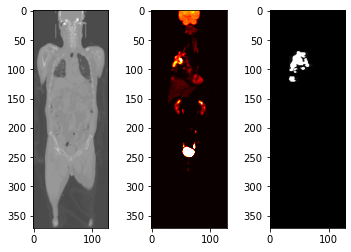

LC01473


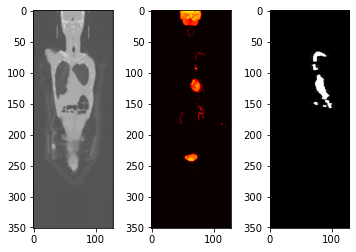

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0600962



LC01475


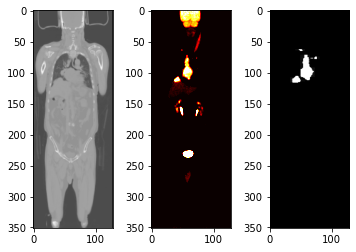

LC01492


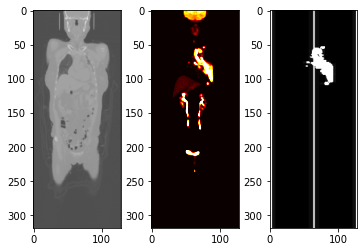

LC01521


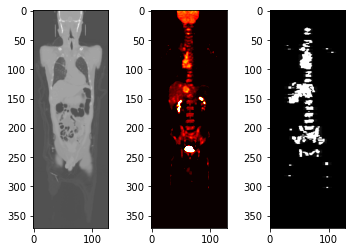

LC01523


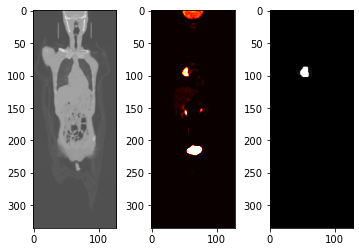

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0799017



LC01551


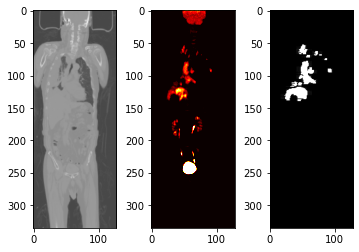

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0600657



LC01860


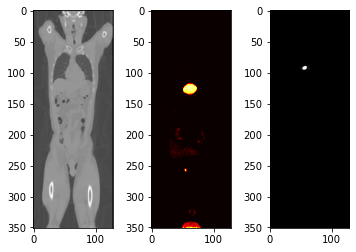

LC01888


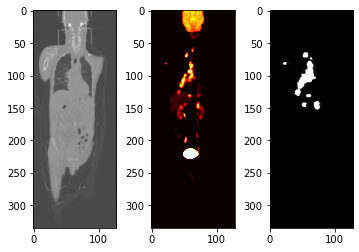

LC01993


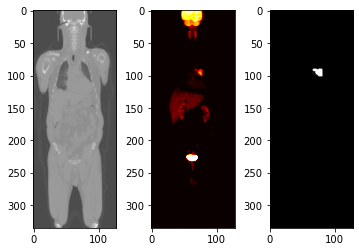

LC01996


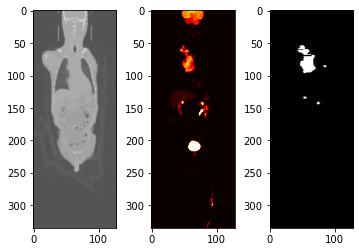

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0801098



LC02157


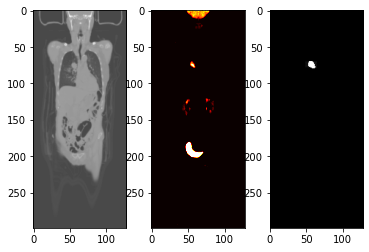

LC02393


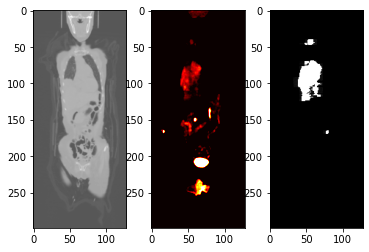

LC02473


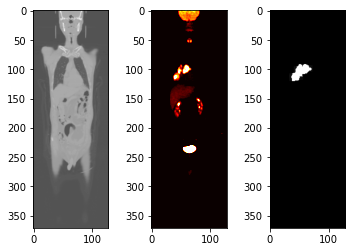

LC02476


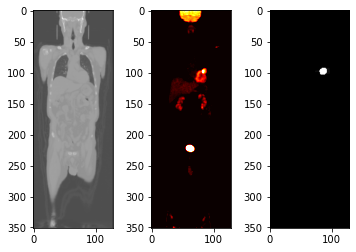

LC02504


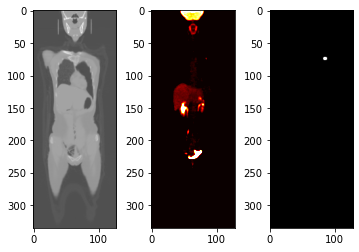

LC02516


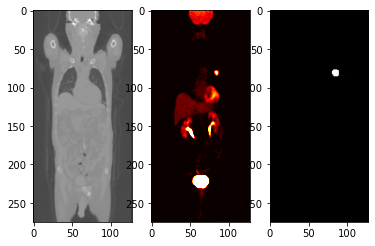

LC02677


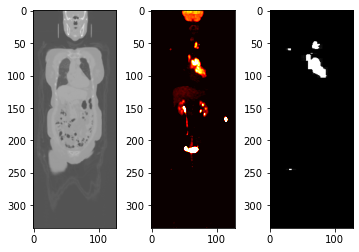

LC02762


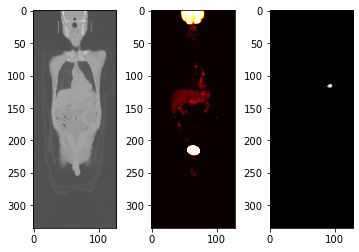

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0798718



LC03036


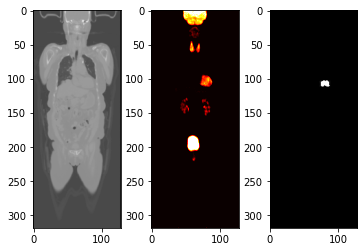

LC03100


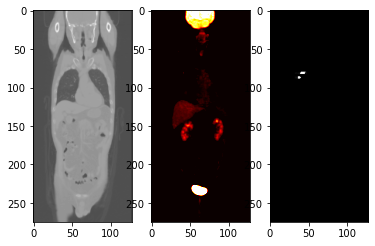

LC03266


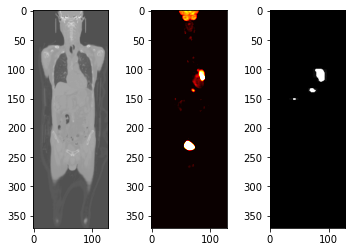

LC03990


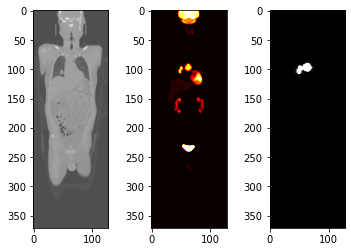

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0600504



LC04040


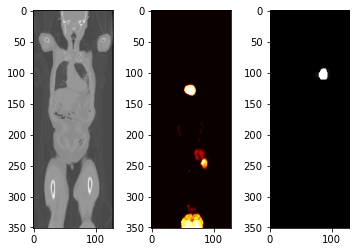

LC04246


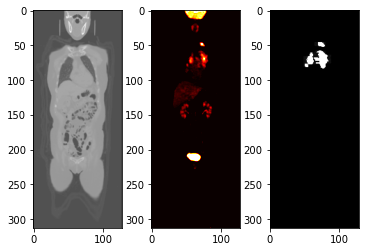

LC04366


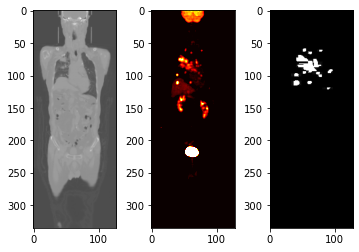

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0799017



LC04452


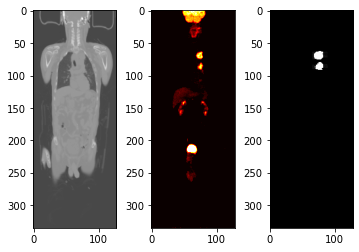

LC04859


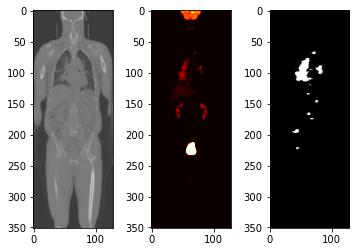

LC05911


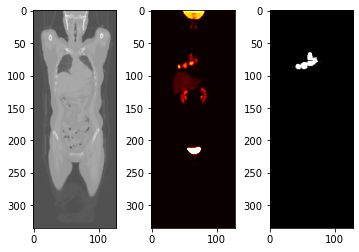

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0600962



LC05936


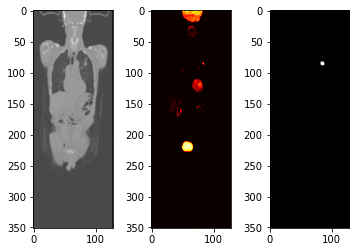

LC06028


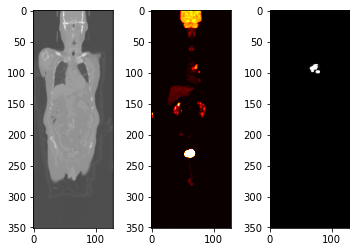

LC06038


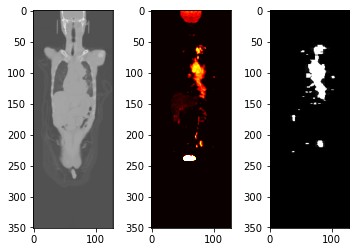

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0800519



LC06187


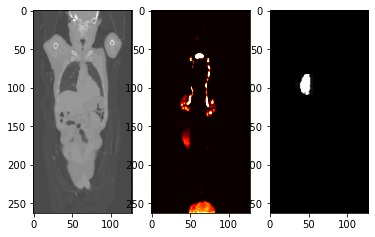

LC06196


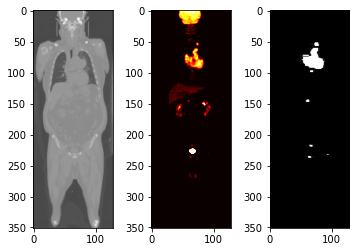

LC06292


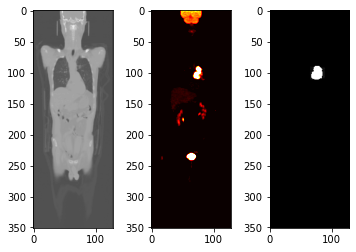

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0801098



LC06298


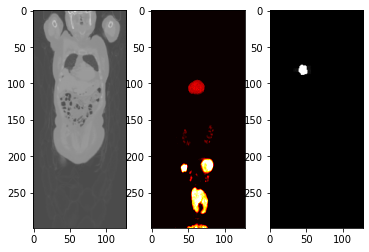

LC06317


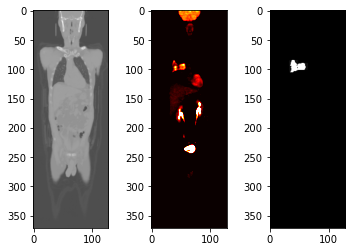

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0600962



LC06321


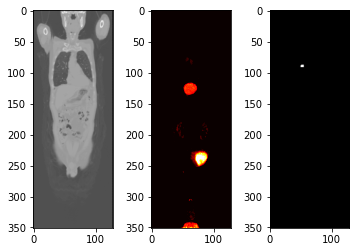

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.079886



LC06338


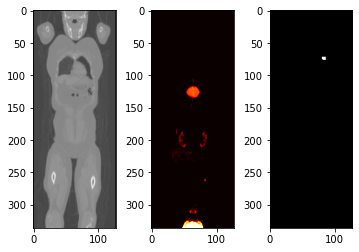

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0599406



LC06342


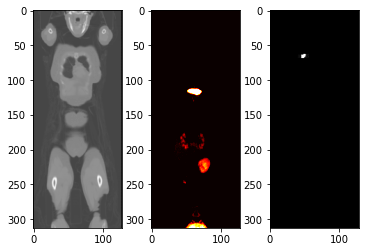

LC06606


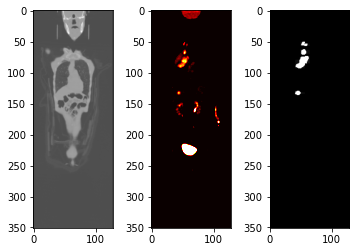

ImageSeriesReader (0x555d6359bca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0600962



LC07317


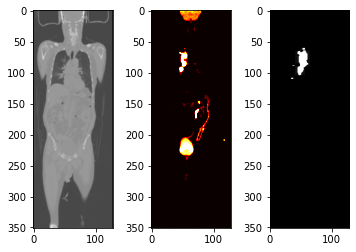

LC08794


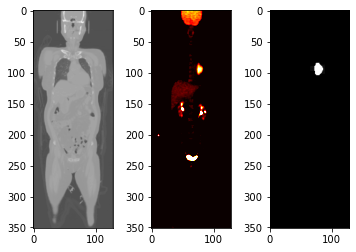

In [ ]:
fdg_root = "FDG"
ct_root="CT"
list_fdg = []
info_fdg = []
list_ct=[]
info_ct=[] 

root_path = "./data_n_400/"
PET_ = "AIDATA_PET_20201105(n=246)_20210202/"
CT_  = "AIDATA_CT_20201105(n=246)_20210202/"

#PET_ = "AIDATA_PET_20210210(n=154)/"
#CT_  = "AIDATA_CT_20210210(n=154)/"

statistics_ = root_path + "AIDATA_NSCLC+SCLC_20201130_tissue(n246)_20210202.xlsx" ## For training
#statistics_ = root_path + "AIDATA_NSCLC+SCLC_20210210_tissue(n154).xlsx" ## For testing
df_clinical_ = pd.read_excel(open(statistics_, 'rb'), sheet_name='Sheet1')  
list_patient_ = df_clinical_['PatientID']
output_ct   = "./data_n_400/storage/train/ct/"
output_mask = "./data_n_400/storage/train/mask/"
#list_patient_= [x for x in list_patient_ if (x not in special_list_id+special_list_id2)]
list_patient_= special_list_id
#list_patient_ = special_list_id2

for Patient_ID_ in list_patient_:
    fdg_root = "FDG"
    ct_root="CT"
    list_fdg = []
    info_fdg = []
    list_ct=[]
    info_ct=[] 

    fdg_dir  = root_path + PET_ + Patient_ID_ + "/" 
    fdg_paths= sorted(glob.glob(fdg_dir+ "IM*"),key=natural_keys)

    ct_dir   = root_path + CT_ + "CT_"+ Patient_ID_ + "/" 
    ct_paths = sorted(glob.glob(ct_dir+ "IM*"),key=natural_keys)
      
    ## Load PET
    for path in fdg_paths:
        num_of_path = path.replace(fdg_dir,"")
        pub_name = fdg_root + "-" + Patient_ID_ + "_" + num_of_path
        dataset = pydicom.dcmread(path)
        info_fdg.append(dataset)
        list_fdg.append(dataset.pixel_array*dataset.RescaleSlope)

    ## Load SUV
    pet_image_file_list = sort_by_instance_number(fdg_paths)
    suv, estimated, raw,spacing,origin,direction = compute_suv(pet_image_file_list)
    
    ## Load CT scan
    for path in ct_paths:
        num_of_path = path.replace(ct_dir,"")
        pub_name = ct_root + "-" + Patient_ID_ + "_" + num_of_path
        dataset = pydicom.dcmread(path)
        info_ct.append(dataset)
        list_ct.append(convert_to_hu(dataset))
    
    ## load ROI
    roi_path = root_path + "AIDATA_ROI_label_PMOD_DICOM(n=400)/" + "ROI_"+ Patient_ID_+".zip"
    roi_temp = np.zeros((128,128))
    count = 0
    with ZipFile(roi_path) as archive:
        for entry in archive.infolist():
            with archive.open(entry) as file:
                count += 1 
                img = np.asarray(Image.open(file).convert("L"))
                roi_temp = np.dstack((roi_temp,img))
    roi_temp = np.delete(roi_temp, 0, axis=2)
    roi_temp = np.transpose(roi_temp, (2, 0, 1))
    roi_3D = norm(roi_temp)*255.
    
    fdg_3D = resize(np.rot90(np.transpose(np.asarray(list_fdg), (2, 1, 0)),k=1, axes=(0, 2)),np.shape(roi_3D))
    ct_3D  = np.rot90(resize(np.asarray(list_ct),np.shape(roi_3D)),k=2, axes=(1, 0)) #for special list 1
    #ct_3D  = resize(np.asarray(list_ct),np.shape(roi_3D)) #for without special list 1&2
    suv_3D = resize(suv,np.shape(roi_3D))
    
    
    bin_suv = np.where(suv_3D>2.5,1,0)
    bin_suv = np.where(roi_3D>=1,bin_suv,0)
    
    b_top  = int(np.shape(ct_3D)[0]*0.1) #0.1 #0.55
    b_bot  = int(np.shape(ct_3D)[0]*0.45) #0.45 #0.9
    b_front= int(np.shape(ct_3D)[1]*0.2)
    b_back = int(np.shape(ct_3D)[1]*0.8)
    b_left = int(np.shape(ct_3D)[2]*0.2)
    b_right= int(np.shape(ct_3D)[2]*0.8)
    
    print(Patient_ID_)
    figure_C = ct_3D[:,70,:]
    #figure_C[b_top:b_bot,b_left:b_right] = 100
    figure_S = map_ax(suv_3D[:,:,:],1)
    figure_M = map_ax(roi_3D[:,:,:],1)
    
    figure, axis = plt.subplots(1, 3)
    
    axis[0].imshow(figure_C, cmap = 'gray')
    axis[1].imshow(figure_S, cmap = 'hot',vmin=2.5,vmax=12)
    axis[2].imshow(figure_M, cmap = 'gray')

    plt.show()
    
    sg_roi = fdg_3D[b_top:b_bot,b_front:b_back,b_left:b_right]
    suv_roi = suv_3D[b_top:b_bot,b_front:b_back,b_left:b_right]
    bin_roi = bin_suv[b_top:b_bot,b_front:b_back,b_left:b_right]
    bg_roi = window_image(ct_3D, -500, 100)[b_top:b_bot,b_front:b_back,b_left:b_right]
    dr_roi = roi_3D[b_top:b_bot,b_front:b_back,b_left:b_right]
    
    hf_mask = h5py.File(output_mask+Patient_ID_+'.h5', 'w')
    hf_ct   = h5py.File(output_ct+Patient_ID_+'.h5', 'w')
    hf_mask.create_dataset('image', data=dr_roi)
    hf_mask.create_dataset('file_id', data=output_mask+Patient_ID_+'.h5')
    hf_mask.create_dataset('training_group', data='train')
    hf_mask.create_dataset('scan_id', data=Patient_ID_)
    
    hf_ct.create_dataset('image', data=bg_roi)
    hf_ct.create_dataset('file_id', data=output_mask+Patient_ID_+'.h5')
    hf_ct.create_dataset('training_group', data='train')
    hf_ct.create_dataset('scan_id', data=Patient_ID_)
    
    
    hf_mask.close()
    hf_ct.close()
    #nrrd.write(output_mask+Patient_ID_+'.nrrd', dr_roi.astype(np.uint16))
    #nrrd.write(output_ct+Patient_ID_+'.nrrd', bg_roi)
    
    del roi_temp, roi_3D, fdg_3D, ct_3D, suv_3D, bin_suv

In [ ]:
plt.imshow(map_ax(fdg_3D,1),cmap="hot",extent=[0,10,0,15])
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(map_ax(roi_3D,1),cmap="hot",extent=[0,10,0,15])
plt.colorbar()
plt.show()

In [ ]:
## ROI by SUV max
plt.imshow(map_ax(suv,1),cmap="hot",extent=[0,10,0,15],vmin=2.5,vmax=12)
plt.colorbar()
plt.show()

In [ ]:
bin_suv = np.where(suv>3,1,0)
plt.imshow(map_ax(bin_suv,1),cmap="hot",extent=[0,10,0,15])
plt.colorbar()
plt.show()

In [ ]:
#img_bg = norm(ct_act_3D[20,:,:])

b_top  = int(np.shape(ct_3D)[0]*0.12)
b_bot  = int(np.shape(ct_3D)[0]*0.37)
b_front= int(np.shape(ct_3D)[1]*0.25)
b_back = int(np.shape(ct_3D)[1]*0.75)
b_left = int(np.shape(ct_3D)[2]*0.25)
b_right= int(np.shape(ct_3D)[2]*0.75)

sg = fdg_3D[b_top:b_bot,b_front:b_back,b_left:b_right]
suv_roi = suv[b_top:b_bot,b_front:b_back,b_left:b_right]
bin_roi = bin_suv[b_top:b_bot,b_front:b_back,b_left:b_right]
bin_roi = bin_suv[b_top:b_bot,b_front:b_back,b_left:b_right]
#bg = window_image(ct_3D, -500, 100)[b_top:b_bot,b_front:b_back,b_left:b_right]

img_sg = bin_roi[:,41,:]
lung_bg = bg[:,41,:]
fig, ax = plt.subplots()
ax.imshow(lung_bg[:,:], cmap = 'gray')
ax.imshow(img_sg[:,:], cmap = 'hot', alpha=0.7)
plt.show()